<a href="https://colab.research.google.com/github/Kryptera-K/A-Gann-Directional-Momentum-Strategy-GDMS-/blob/main/A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "A"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("A_clean.csv", index=False)
df

/tmp/ipython-input-412116187.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,43.113312,47.267457,40.343878,47.155182,4674353
2000-01-04,39.819946,41.242088,38.772052,40.792988,4765083
2000-01-05,37.349903,39.819938,36.114889,39.670237,5758642
2000-01-06,35.927769,37.125364,34.805026,36.900814,2534434
2000-01-07,38.921757,39.483128,35.328981,35.366404,2819626
...,...,...,...,...,...
2025-10-31,146.360001,146.990005,142.600006,142.779999,1487200
2025-11-03,144.690002,145.580002,142.529999,145.070007,1785800
2025-11-04,146.080002,148.710007,143.500000,143.500000,2176600


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

ADX_LEVEL = 20
ADX_PERIOD = 14
ADX_SHIFT = 5
DI_PERIOD = 14
DI_SHIFT_1 = 5
DI_SHIFT_2 = 10
GANN_SHIFT = 1
RSI_OVERBOUGHT_LEVEL = 70
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14
RSI_SHIFT = 5
RSI_SHIFT_2 = 10

# -------------------------
# Indicator Functions
# -------------------------

def gann_is_downtrend(df, shift=GANN_SHIFT):
    df = calculate_gann_trend(df, shift)
    return df['Gann_DownTrend']


def calculate_gann_trend(df, shift=GANN_SHIFT):
    """
    Calculate Gann Hi-Lo Trend and reference bars.
    """
    df = df.copy()
    # Previous bar high/low/open
    df['Gann_High'] = df['High'].shift(shift)
    df['Gann_Low'] = df['Low'].shift(shift)
    df['Prev_High'] = df['High'].shift(shift)
    df['Prev_Low'] = df['Low'].shift(shift)
    df['Prev_Open'] = df['Open'].shift(shift)

    # Trend
    df['Gann_UpTrend'] = df['Close'] > df['Gann_Low']
    df['Gann_DownTrend'] = df['Close'] < df['Gann_High']

    return df


def di_minus_change_direction_downward(df, shift_1=DI_SHIFT_1, shift_2=DI_SHIFT_2):
    df = calculate_di(df)
    return (df['DI-'].shift(shift_1) < df['DI-'].shift(shift_2)) & (df['DI-'] < df['DI-'].shift(shift_1))


def calculate_di(df, period=DI_PERIOD):
    """
    Calculate DI+ and DI- indicators.
    """
    df = df.copy()

    # True Range
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    # +DM and -DM
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    # Wilder’s smoothing
    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    # DI+ and DI-
    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])

    return df


def adx_is_rising(df, period=ADX_PERIOD):
    df = calculate_adx(df, period)
    return df['ADX'].diff() > 0


def calculate_adx(df, period=14):
    """
    Calculate ADX and related columns.
    """

    # True Range (TR)
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    # Directional Movement (DM)
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    # Smoothed values
    df['TRn'] = df['TR'].rolling(window=period).sum()
    df['+DMn'] = df['+DM'].rolling(window=period).sum()
    df['-DMn'] = df['-DM'].rolling(window=period).sum()

    # Calculate +DI and -DI
    df['+DI'] = 100 * (df['+DMn'] / df['TRn'])
    df['-DI'] = 100 * (df['-DMn'] / df['TRn'])

    # DX and ADX
    df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window=period).mean()

    return df


def rsi_cross_above_os(df, level=RSI_OVERSOLD_LEVEL):
    df = calculate_rsi(df)
    return (df['RSI'].shift(RSI_SHIFT) <= level) & (df['RSI'] > level)


def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Gann_DownTrend"] = gann_is_downtrend(df)
df["DI-_Change_Direction_Downward"] = di_minus_change_direction_downward(df)

# -------------------------
# Exit conditions
# -------------------------

df["ADX_Rising"] = adx_is_rising(df)
df["RSI_Cross_Above_OS"] = rsi_cross_above_os(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Gann_DownTrend',
    'DI-_Change_Direction_Downward',
]
exit_conditions = [
    'ADX_Rising',
    'RSI_Cross_Above_OS',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-11-07 00:00:00
Period                                6503 days 00:00:00
Start Value                                     100000.0
End Value                                 1032179.463382
Total Return [%]                              932.179463
Benchmark Return [%]                          210.718774
Max Gross Exposure [%]                             100.0
Total Fees Paid                             61117.858305
Max Drawdown [%]                               90.071827
Max Drawdown Duration                 2930 days 00:00:00
Total Trades                                          99
Total Closed Trades                                   98
Total Open Trades                                      1
Open Trade PnL                             315481.351606
Win Rate [%]                                        50.0
Best Trade [%]                                135.273107
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-11-06 00:00:00
Period                         6502 days 00:00:00
Start Value                              100000.0
End Value                           309170.670808
Total Return [%]                       209.170671
Benchmark Return [%]                   209.170671
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        93.141027
Max Drawdown Duration          5129 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      209170.670808
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2401423207.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


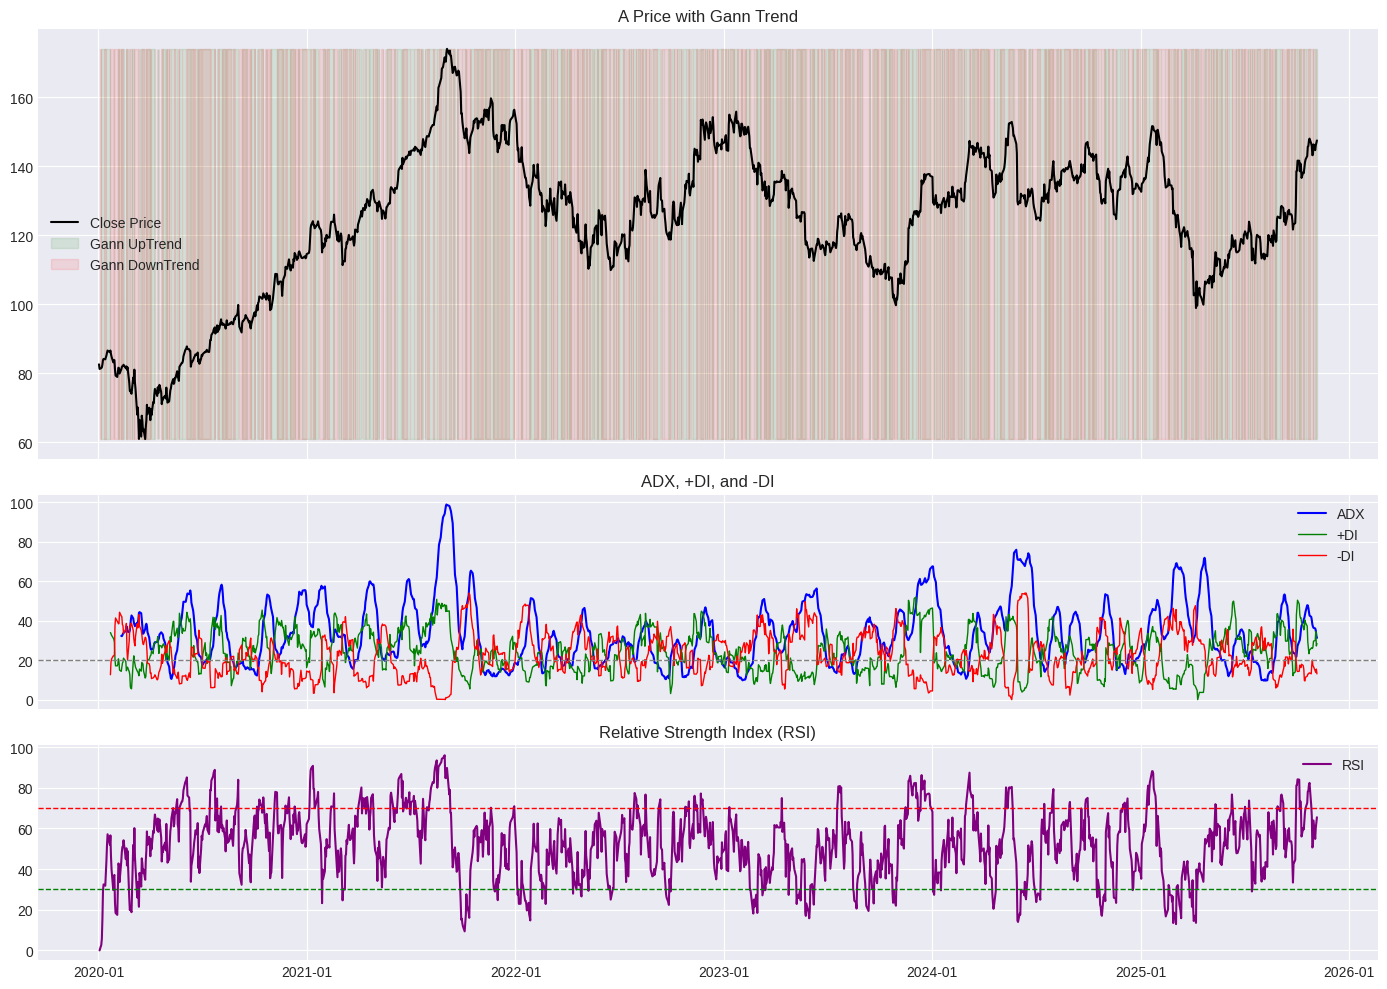

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -------------------------
# Download Data
# -------------------------
symbol = "A"
start_date = "2020-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Indicator Calculation Functions
# -------------------------

def calculate_gann_trend(df, shift=1):
    df = df.copy()
    df['Gann_High'] = df['High'].shift(shift)
    df['Gann_Low'] = df['Low'].shift(shift)
    df['Gann_UpTrend'] = df['Close'] > df['Gann_Low']
    df['Gann_DownTrend'] = df['Close'] < df['Gann_High']
    return df

def calculate_di(df, period=14):
    df = df.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
    return df

def calculate_adx(df, period=14):
    df = calculate_di(df, period)
    df['DX'] = 100 * abs(df['DI+'] - df['DI-']) / (df['DI+'] + df['DI-'])
    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

def calculate_rsi(df, period=14):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

# -------------------------
# Calculate Indicators
# -------------------------
df = calculate_gann_trend(df)
df = calculate_adx(df, period=14)
df = calculate_rsi(df, period=14)

# -------------------------
# Plot Section
# -------------------------
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios':[2,1,1]})

# --- 1. Price with Gann Trend ---
axes[0].plot(df.index, df['Close'], label='Close Price', color='black')
axes[0].fill_between(df.index, df['Close'].min(), df['Close'].max(),
                     where=df['Gann_UpTrend'], color='green', alpha=0.1, label='Gann UpTrend')
axes[0].fill_between(df.index, df['Close'].min(), df['Close'].max(),
                     where=df['Gann_DownTrend'], color='red', alpha=0.1, label='Gann DownTrend')
axes[0].set_title(f"{symbol} Price with Gann Trend")
axes[0].legend()

# --- 2. ADX and DI ---
axes[1].plot(df.index, df['ADX'], label='ADX', color='blue', linewidth=1.5)
axes[1].plot(df.index, df['DI+'], label='+DI', color='green', linewidth=1)
axes[1].plot(df.index, df['DI-'], label='-DI', color='red', linewidth=1)
axes[1].axhline(20, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('ADX, +DI, and -DI')
axes[1].legend()

# --- 3. RSI ---
axes[2].plot(df.index, df['RSI'], label='RSI', color='purple')
axes[2].axhline(70, color='red', linestyle='--', linewidth=1)
axes[2].axhline(30, color='green', linestyle='--', linewidth=1)
axes[2].set_title('Relative Strength Index (RSI)')
axes[2].legend()

# --- Formatting ---
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.tight_layout()
plt.show()
